- Pradeep Gahlawat
- 10524011
- Driver drowsiness detection system
- file 4/4 (Proposed model LSTM)

In [1]:
# import used libraries and fucntions
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
from keras.utils import to_categorical
from keras.layers import Dense, Flatten, Dropout, ZeroPadding3D
from keras.layers.recurrent import LSTM
from keras.models import Sequential, load_model
from keras.optimizers import Adam, RMSprop
from keras.layers.wrappers import TimeDistributed
from keras.layers.convolutional import (Conv2D, MaxPooling3D, Conv3D,MaxPooling2D)
from collections import deque
import sys
import seaborn as sb
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score, f1_score
from sklearn.metrics import accuracy_score
from sklearn import metrics

Using TensorFlow backend.


## Data Collection

In [2]:
# Collect normalised data for both classes 
df_alert = pd.read_csv('normalised_alert.csv', index_col=None, header=0)
df_drowsy = pd.read_csv('normalised_drowsy.csv', index_col=None, header= 0)
df = pd.concat([df_alert, df_drowsy], axis=0, join='inner', ignore_index=True)

# aggregate entire data based on subject number to randomly shuffle subjects
groups = [df for _, df in df.groupby('Subject')]
random.shuffle(groups)
df = pd.concat(groups).reset_index(drop=True)

## Split dataset into train and test sets

In [3]:
# Setting train and test index to split data into roughly 3:1 ratio for train and test respectively.
train_index = 9600
test_index = len(df)-train_index
df_train = df[:train_index]
df_test = df[-test_index:]

# print total number of subjects in both train and test data
Total_subjects = len(df_train['Subject'].value_counts())
print('Total subjects in train set: {0}'.format(Total_subjects))
Total_subjects = len(df_test['Subject'].value_counts())
print('Total subjects in test set: {0}'.format(Total_subjects))

Total subjects in train set: 20
Total subjects in test set: 7


In [4]:
# # saving test and train data for future use
# df_train.to_csv('df_train_for_LSTM_7Features.csv',index=False, header = True)
# df_test.to_csv('df_test_for_LSTM_7Features.csv',index=False, header = True)

In [5]:
# get features matrix and labels vector for both train and test data
X_train = df_train[['EAR', 'MAR', 'CIR', 'MOE', 'PITCH', 'ROLL', 'YAW']]
y_train = df_train['Label']
print(X_train.shape, y_train.shape)

X_test = df_test[['EAR', 'MAR', 'CIR', 'MOE', 'PITCH', 'ROLL', 'YAW']]
y_test = df_test["Label"]
print(X_test.shape, y_test.shape)

(9600, 7) (9600,)
(3360, 7) (3360,)


### Transform shape of the input data 

In [6]:
# transform feature matrix shape to 3 dimensions for LSTM layer
X_train_new  = np.array(X_train).reshape(1920,5,7)
print(X_train_new.shape)
X_test_new  = np.array(X_test).reshape(672,5,7)
print(X_test_new.shape)

(1920, 5, 7)
(672, 5, 7)


In [7]:
# similarly, transform labels shape to match batch size (5)
y_train = np.array(y_train)
y_train_new  = []
for i in range(0, len(y_train), 5):
    y_train_new.append([y_train[i]])
y_train_new = np.array(y_train_new)
print(y_train_new.shape)

y_test = np.array(y_test)
y_test_new  = []
for i in range(0, len(y_test), 5):
    y_test_new.append([y_test[i]])
y_test_new = np.array(y_test_new)
print(y_test_new.shape)

(1920, 1)
(672, 1)


## Long Short Term Memory 

### Training

In [8]:
metrics = ['accuracy']
model = Sequential()
model.add(Dense(1024, activation ='sigmoid'))
model.add(LSTM(512, return_sequences = True, input_shape = (5, 7,),dropout = 0.5))

model.add(Flatten())
model.add(Dense(256, activation='sigmoid')) #FC1
model.add(Dense(32, activation='tanh')) #FC2
model.add(Dropout(0.5))
model.add(Dense(16, activation='relu'))#FC3
model.add(Dropout(0.5))
model.add(Dense(1, activation='tanh'))#Output Layer
optimizer = Adam(lr=0.00005)
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics= metrics)
model.fit(X_train_new, y_train_new, validation_data = (X_test_new,y_test_new), epochs=50, batch_size=  5)

Train on 1920 samples, validate on 672 samples
Epoch 1/50
1920/1920 [==============================] - 11s 6ms/step - loss: 1.8392 - accuracy: 0.5083 - val_loss: 0.6614 - val_accuracy: 0.6176
Epoch 2/50
1920/1920 [==============================] - 10s 5ms/step - loss: 1.1256 - accuracy: 0.5464 - val_loss: 0.6460 - val_accuracy: 0.6429
Epoch 3/50
1920/1920 [==============================] - 8s 4ms/step - loss: 1.2451 - accuracy: 0.5318 - val_loss: 1.0249 - val_accuracy: 0.5000
Epoch 4/50
1920/1920 [==============================] - 8s 4ms/step - loss: 1.2845 - accuracy: 0.5047 - val_loss: 0.6738 - val_accuracy: 0.6071
Epoch 5/50
1920/1920 [==============================] - 8s 4ms/step - loss: 1.1272 - accuracy: 0.5307 - val_loss: 0.6702 - val_accuracy: 0.6146
Epoch 6/50
1920/1920 [==============================] - 8s 4ms/step - loss: 1.0444 - accuracy: 0.5234 - val_loss: 0.6332 - val_accuracy: 0.6205
Epoch 7/50
1920/1920 [==============================] - 8s 4ms/step - loss: 0.9479 - ac

### Evaluation

In [9]:
# get predictions and predicted probabilities for evaluation
y_test_predicted = model.predict_classes(X_test_new)
y_train_predicted = model.predict_classes(X_train_new)  

y_test_predicted_prob = model.predict_proba(X_test_new)
y_train_predicted_prob = model.predict_proba(X_train_new)

Text(0.5, 0, 'False Positive Rate')

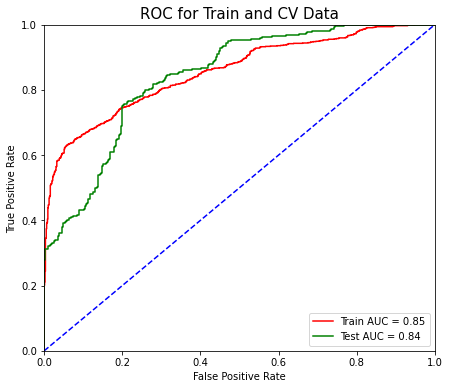

In [10]:
# ROC and AUC value on train data
plt.figure(figsize=(7,6))
fpr, tpr, threshold = roc_curve(y_train_new, y_train_predicted_prob)
roc_auc_train = roc_auc_score(y_train_new, y_train_predicted_prob)
plt.plot(fpr, tpr, 'r', label = 'Train AUC = %0.2f' % roc_auc_train)
plt.legend(loc = 'lower right')

# ROC and AUC value on test data
fpr, tpr, threshold = roc_curve(y_test_new, y_test_predicted_prob)
roc_auc_test = roc_auc_score(y_test_new, y_test_predicted_prob)
plt.plot(fpr, tpr, 'g', label = 'Test AUC = %0.2f' % roc_auc_test)
plt.legend(loc = 'lower right')

plt.plot([0, 1], [0, 1],'b--')
plt.title('ROC for Train and CV Data', size = 15)
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')    

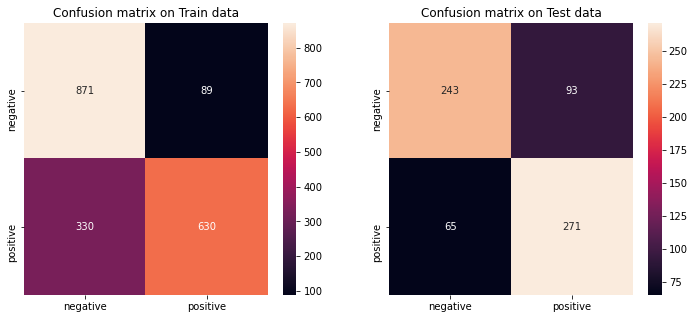

In [11]:
# plot confusion matrix on train data
fig = plt.figure(figsize=(12,5))
ax1 = fig.add_subplot(121)
ax1.title.set_text('Confusion matrix on Train data')
conf_matrix_train = confusion_matrix(y_train_new, y_train_predicted)
class_label = ['negative', 'positive']
df_conf_matrix = pd.DataFrame(conf_matrix_train, index=class_label, columns=class_label)
sb.heatmap(df_conf_matrix, annot=True, fmt='d')
# plot confusion matrix on test data
ax2 = fig.add_subplot(122)
ax2.title.set_text('Confusion matrix on Test data')
conf_matrix_test = confusion_matrix(y_test_new, y_test_predicted)
df_conf_matrix = pd.DataFrame(conf_matrix_test, index=class_label, columns=class_label)
sb.heatmap(df_conf_matrix, annot=True, fmt='d')
plt.show()

In [12]:
from sklearn import metrics
# Model Accuracy: how often is the classifier correct?
print("Accuracy:", accuracy_score(y_test_new, y_test_predicted))
# Model Precision: what percentage of positive tuples are labeled as such?
print("Precision:", metrics.precision_score(y_test_new, y_test_predicted))
# Model Recall: what percentage of positive tuples are labelled as such?
print("Recall:", metrics.recall_score(y_test_new, y_test_predicted))
# Model Recall: what percentage of positive tuples are labelled as such?
print("F1_score:", f1_score(y_test_new, np.array(y_test_predicted)))

Accuracy: 0.7648809523809523
Precision: 0.7445054945054945
Recall: 0.8065476190476191
F1_score: 0.7742857142857142
